In [52]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler #scaling de los datos entre 0 y 1
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [53]:
def format_l(df, l):
    x = []
    y = []
    max_lim = len(df) - l - 1
    for i in range(max_lim):
        fila_datos = df[i: (i+l), 0]
        x.append(fila_datos)
        y.append(df[i+l,0])
    x = np.array(x)
    y = np.array(y)
    return x,y

In [54]:
def graph_predictions(name,l,df_original,y_train_pr,y_test_pr):
    plt.plot(df_original) #los datos originales
    #calculo meses de resultados de train y test, tengo cuidado con el delay l de los dias
    months_tr = np.arange(l,len(y_train_pr)+l) #meses de training
    months_ts = np.arange(len(y_train_pr)+(2*l)+1,len(df_original)-1) #meses de testing
    plt.plot(months_tr,y_train_pr,label='train') #grafico de train results
    plt.plot(months_ts,y_test_pr,label='test') #grafico de test results
    plt.xlabel('Meses')
    plt.ylabel('Pasajeros')
    plt.legend()
    plt.grid()
    plt.savefig(str(name)+'.pdf')
    plt.show()

In [55]:
def first_model(l=1,dp=0,graph=False,name=''):
    #punto 1: cargo los datos y les hago un primer formatting
    file_dir = 'airline-passengers.csv'
    data = pd.read_csv(file_dir,sep=",",quotechar='"',na_values=[''])
    df = pd.DataFrame(data)
    df = df.drop(columns=['Month']) #no hace falta esta columna para nada
    df = df.to_numpy() #me paso a numpy array
    df_original = np.copy(df)
    #punto 2: normalizo entre 0 y 1
    scaling = MinMaxScaler(feature_range=(0,1))
    df = scaling.fit_transform(df)
    #punto 3: agrego ruido gaussiano pedido
    df += np.random.normal(0,0.02,df.shape)
    #punto 4: dividir en conjuntos de train y test
    train_samples = int(0.5*df.shape[0])
    d_tr = df[:train_samples]
    d_ts = df[train_samples:]
    x_train,y_train = format_l(d_tr,l)
    x_test,y_test = format_l(d_ts,l)
    #punto 5: ajustar los datos para la capa LSTM (samples, time, features)
    x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
    x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
    #punto 6: crear el modelo
    model = keras.Sequential()
    model.add(keras.layers.LSTM(4, input_shape=(1,l),recurrent_dropout=dp)) #input_shape = (1,l) sin el samples, analogo a redes anteriores
    model.add(keras.layers.Dense(1))
    #punto 7: entrenar la red
    model.compile(optimizer='adam',loss=keras.losses.MSE,metrics=['mse']) #no metrics porque seria mse, compilo
    history = model.fit(x_train, y_train,epochs=100,validation_data=(x_test,y_test),batch_size=1,verbose=0) #entreno el modelo
    #punto 8: realizar predicciones
    y_train_pr = model.predict(x_train)
    y_test_pr = model.predict(x_test)
    #invertir predicciones
    y_train_pr = scaling.inverse_transform(y_train_pr)
    y_train = scaling.inverse_transform([y_train])
    y_test_pr = scaling.inverse_transform(y_test_pr)
    y_test = scaling.inverse_transform([y_test])
    #calcular el mse para test
    mse_train = mean_squared_error(y_train[0], y_train_pr[:,0])
    mse_test = mean_squared_error(y_test[0], y_test_pr[:,0])
    print('MSE para train dataset:',round(mse_train,1))
    print('MSE para test dataset:',round(mse_test,1))
    #grafico
    if graph == True:
        graph_predictions(name,l,df_original,y_train_pr,y_test_pr)
    return history,mse_train,mse_test

MSE para train dataset: 557.0
MSE para test dataset: 2191.7


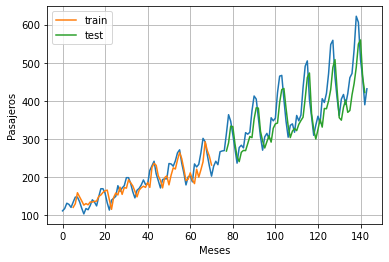

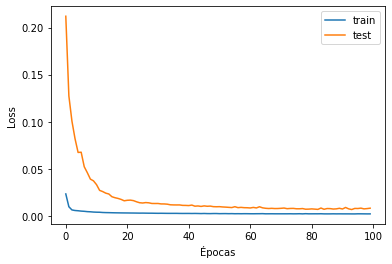

In [51]:
#inciso 8 en el que hago con l=1 una vez la prediccion
def inc_8():
    dp = 0
    l = 1
    name = 'ej1_8_l1'
    history,mse_train,mse_test = first_model(l=l,dp=dp,graph=True,name=name)
    plt.plot(history.history['loss'],label='train')
    plt.plot(history.history['val_loss'],label='test')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('ej1_8_l1_loss.pdf')
inc_8()

En l:  1 

MSE para train dataset: 649.5
MSE para test dataset: 2272.5
En l:  2 

MSE para train dataset: 564.7
MSE para test dataset: 5388.4
En l:  3 

MSE para train dataset: 609.8
MSE para test dataset: 3046.0
En l:  4 

MSE para train dataset: 596.6
MSE para test dataset: 3551.5
En l:  5 

MSE para train dataset: 484.1
MSE para test dataset: 12015.8
En l:  6 

MSE para train dataset: 526.9
MSE para test dataset: 2987.3
En l:  7 

MSE para train dataset: 585.6
MSE para test dataset: 3261.4
En l:  8 

MSE para train dataset: 467.4
MSE para test dataset: 2654.9
En l:  9 

MSE para train dataset: 460.0
MSE para test dataset: 7676.5
En l:  10 

MSE para train dataset: 487.8
MSE para test dataset: 5286.0
En l:  11 

MSE para train dataset: 354.8
MSE para test dataset: 2019.0
En l:  12 

MSE para train dataset: 263.0
MSE para test dataset: 5382.7
En l:  13 

MSE para train dataset: 347.1
MSE para test dataset: 6853.6
En l:  14 

MSE para train dataset: 251.0
MSE para test dataset: 13853.4

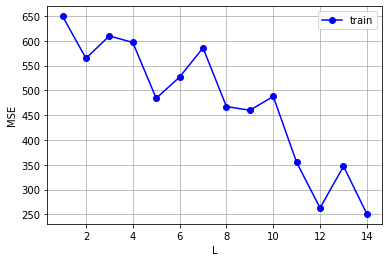

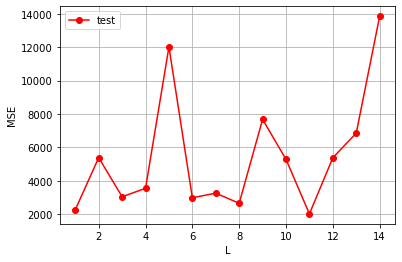

In [32]:
#inciso 9 en el que hago con l=[1,10] para ver como va con las predicciones, promedia 10 veces
def inc_9():
    dp = 0
    ls = np.arange(1,15)
    mean_mse_tr = []
    mean_mse_ts = []
    rep_max = 1
    for l in ls:
        print('En l: ',l,'\n')
        history,mse_train,mse_test = history,mse_train,mse_test = first_model(l=l,dp=dp)
        aux_tr = mse_train
        aux_ts = mse_test
        mean_mse_tr.append(aux_tr)
        mean_mse_ts.append(aux_ts)
    plt.plot(ls,mean_mse_tr,'-ob',label='train')
    plt.legend()
    plt.xlabel('L')
    plt.ylabel('MSE')
    plt.grid()
    plt.savefig('ej9_train_l.pdf')
    plt.figure()
    plt.plot(ls,mean_mse_ts,'-or',label='test')
    plt.legend()
    plt.xlabel('L')
    plt.ylabel('MSE')
    plt.grid()
    plt.savefig('ej9_test_l.pdf')
inc_9()

In [56]:
#third model prediction using simple rnn from keras 
#another suggestion from slack
#the most simple possible using dense layers
def second_model(l=1,dp=0,graph=False,name=''):
    #punto 1: cargo los datos y les hago un primer formatting
    file_dir = 'airline-passengers.csv'
    data = pd.read_csv(file_dir,sep=",",quotechar='"',na_values=[''])
    df = pd.DataFrame(data)
    df = df.drop(columns=['Month']) #no hace falta esta columna para nada
    df = df.to_numpy() #me paso a numpy array
    df_original = np.copy(df)
    #punto 2: normalizo entre 0 y 1
    scaling = MinMaxScaler(feature_range=(0,1))
    df = scaling.fit_transform(df)
    #punto 3: agrego ruido gaussiano pedido
    df += np.random.normal(0,0.02,df.shape)
    #punto 4: dividir en conjuntos de train y test
    train_samples = int(0.5*df.shape[0])
    d_tr = df[:train_samples]
    d_ts = df[train_samples:]
    x_train,y_train = format_l(d_tr,l)
    x_test,y_test = format_l(d_ts,l)
    #punto 6: crear el modelo
    model = keras.Sequential()
    model.add(keras.layers.Dense(4,activation='relu',input_shape=(l,))) #input_shape = (1,l) sin el samples, analogo a redes anteriores
    #model.add(keras.layers.Dense(4,activation='relu'))
    model.add(keras.layers.Dense(1))
    #punto 7: entrenar la red
    model.compile(optimizer='adam',loss=keras.losses.MSE,metrics=['mse']) #no metrics porque seria mse, compilo
    history = model.fit(x_train, y_train,epochs=100,validation_data=(x_test,y_test),batch_size=1,verbose=0) #entreno el modelo
    #punto 8: realizar predicciones
    y_train_pr = model.predict(x_train)
    y_test_pr = model.predict(x_test)
    #invertir predicciones
    y_train_pr = scaling.inverse_transform(y_train_pr)
    y_train = scaling.inverse_transform([y_train])
    y_test_pr = scaling.inverse_transform(y_test_pr)
    y_test = scaling.inverse_transform([y_test])
    #calcular el mse para test
    mse_train = mean_squared_error(y_train[0], y_train_pr[:,0])
    mse_test = mean_squared_error(y_test[0], y_test_pr[:,0])
    print('MSE para train dataset:',round(mse_train,1))
    print('MSE para test dataset:',round(mse_test,1))
    #grafico
    if graph == True:
        graph_predictions(name,l,df_original,y_train_pr,y_test_pr)
    return history,mse_train,mse_test
    

MSE para train dataset: 686.2
MSE para test dataset: 3822.8


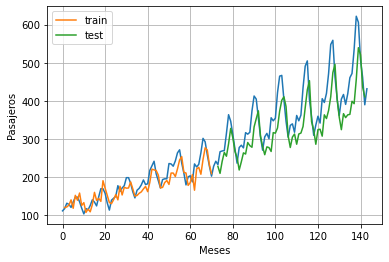

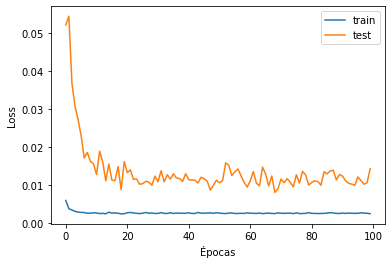

In [60]:
#inciso 10 1 en el que hago con l=1 una vez la prediccion
def inc_10():
    dp = 0
    l = 1
    name = 'ej1_10_l1'
    history,mse_train,mse_test = second_model(l=l,dp=dp,graph=True,name=name)
    plt.plot(history.history['loss'],label='train')
    plt.plot(history.history['val_loss'],label='test')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('ej1_10_l1_loss.pdf')
inc_10()